In [4]:
#Подключаем библиотеки
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D, MaxPooling1D
from keras.utils import plot_model
from google.colab import files
from tensorflow.keras import utils
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import zipfile #Для разорхивации базы

#Разорхивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/datasets/voice/genres.zip', 'r')
z.extractall()
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()

#Проверяем выгруженные папки
!ls genres 
#И одну из папок
!ls genres/blues

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock
blues.00000.au	blues.00020.au	blues.00040.au	blues.00060.au	blues.00080.au
blues.00001.au	blues.00021.au	blues.00041.au	blues.00061.au	blues.00081.au
blues.00002.au	blues.00022.au	blues.00042.au	blues.00062.au	blues.00082.au
blues.00003.au	blues.00023.au	blues.00043.au	blues.00063.au	blues.00083.au
blues.00004.au	blues.00024.au	blues.00044.au	blues.00064.au	blues.00084.au
blues.00005.au	blues.00025.au	blues.00045.au	blues.00065.au	blues.00085.au
blues.00006.au	blues.00026.au	blues.00046.au	blues.00066.au	blues.00086.au
blues.00007.au	blues.00027.au	blues.00047.au	blues.00067.au	blues.00087.au
blues.00008.au	blues.00028.au	blues.00048.au	blues.00068.au	blues.00088.au
blues.00009.au	blues.00029.au	blues.00049.au	blues.00069.au	blues.00089.au
blues.00010.au	blues.00030.au	blues.00050.au	blues.00070.au	blues.00090.au
blues.00011.au	blues.00031.au	blues.00051.au	blues.00071.au	blues.00091.au
blues.00012.au	blues.00032.a

In [25]:
#Функция параметризации аудио
def get_features_2d(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) #Частота цветности
  rmse = librosa.feature.rmse(y=y) #Среднеквадратичная амплитуда
  spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) #Спектральный центроид
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел спектральные коэффициенты
  
  #Возвращаем получившийся список
  return mfcc, chroma_stft, rmse, spec_cent

In [26]:
import time #Для подсчёта времени на обработку одного жанра

#Формируем обучающую выборку
#Создаём пустые листы
X_train_mfcc = []
X_train_chroma_stft = []
X_train_rmse = []
X_train_spec_cent = []
Y_train = []
#Запоминаем время старта формирования выборки
curr_time = time.time()

seconds = 20

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые %seconds% секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=seconds)

    #Превращаем сигнал в параметризованные данные
    for sec in range(seconds):
      mfcc, chroma_stft, rmse, spec_cent = get_features_2d(y[sec*sr:(sec+1)*sr], sr)
      X_train_mfcc.append(mfcc)
      X_train_chroma_stft.append(chroma_stft)
      X_train_rmse.append(rmse)
      X_train_spec_cent.append(spec_cent)
      Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train_mfcc = np.array(X_train_mfcc)
X_train_chroma_stft = np.array(X_train_chroma_stft)
X_train_rmse = np.array(X_train_rmse)
X_train_spec_cent = np.array(X_train_spec_cent)
Y_train = np.array(Y_train)

Жанр blues готов -> 89c
Жанр classical готов -> 89c
Жанр country готов -> 89c
Жанр disco готов -> 89c
Жанр hiphop готов -> 89c
Жанр jazz готов -> 90c
Жанр metal готов -> 90c
Жанр pop готов -> 90c
Жанр reggae готов -> 91c
Жанр rock готов -> 93c


In [27]:
# Решейпим данные для нейронки
X_train_mfcc = X_train_mfcc.reshape(X_train_mfcc.shape[0], X_train_mfcc.shape[1], X_train_mfcc.shape[2], 1)
X_train_chroma_stft = X_train_chroma_stft.reshape(X_train_chroma_stft.shape[0], X_train_chroma_stft.shape[1], X_train_chroma_stft.shape[2], 1)
X_train_rmse = X_train_rmse.reshape(X_train_rmse.shape[0], X_train_rmse.shape[2], X_train_rmse.shape[1])
X_train_spec_cent = X_train_spec_cent.reshape(X_train_spec_cent.shape[0], X_train_spec_cent.shape[2], X_train_spec_cent.shape[1])

In [28]:
# Создаем маску для обучающей и проверочной выборки
val_mask = np.random.sample(20000)
train_mask = val_mask < 0.9
val_mask = val_mask >= 0.9

# Функция нормализации
def scale(X):
  min_X = X.min()
  max_X = X.max()
  X = (X - min_X) / (max_X - min_X)
  return X

In [29]:
# Нормализация
X_train_mfcc_scaled = scale(X_train_mfcc)
X_train_chroma_stft_scaled = scale(X_train_chroma_stft)
X_train_rmse_scaled = scale(X_train_rmse)
X_train_spec_cent_scaled = scale(X_train_spec_cent)

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 20, 44, 1)]  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 12, 44, 1)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 44, 1)]      0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 44, 1)]      0                                            
_______________________________________________________________________________________

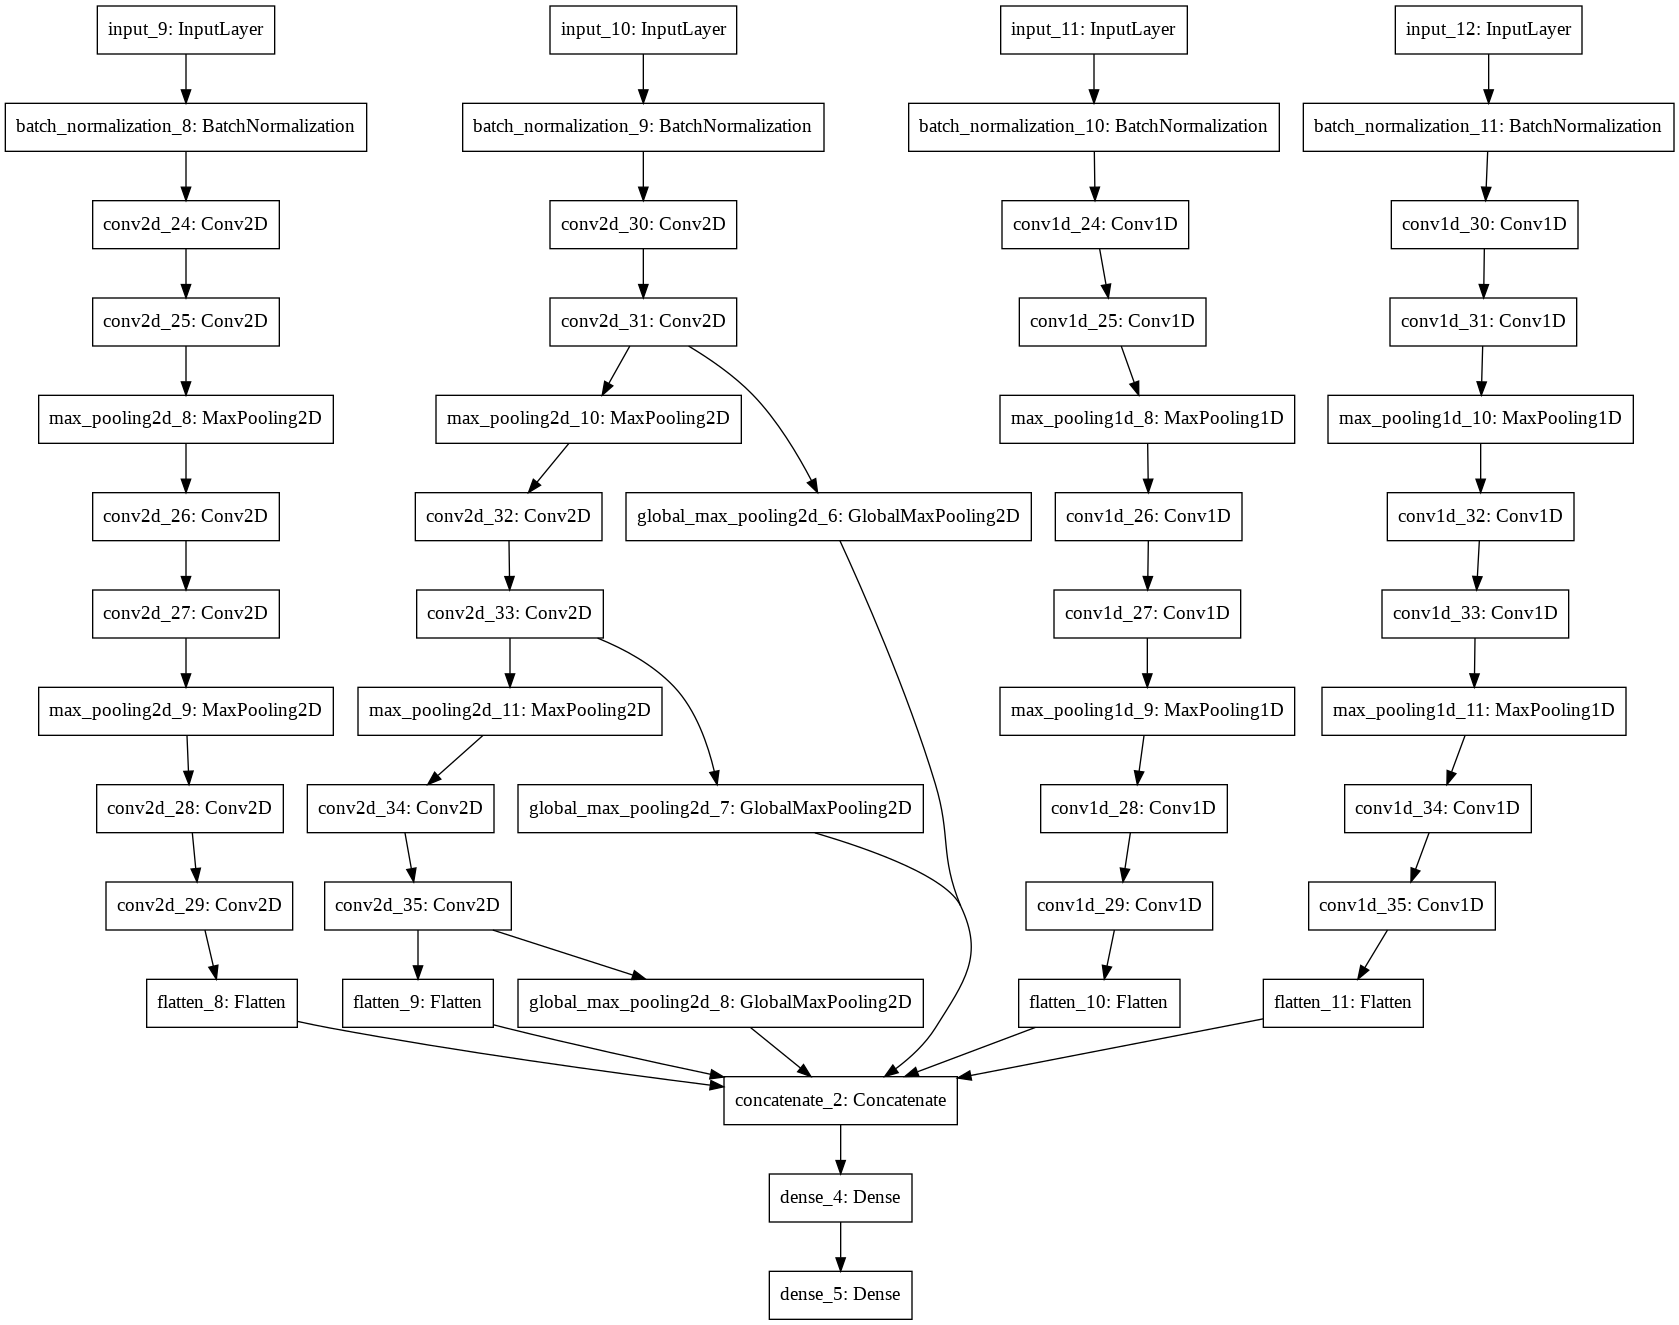

In [30]:
# Создаём модель

input_mfcc = Input((20, 44, 1))
input_chroma_stft = Input((12, 44, 1))
input_rmse = Input((44, 1))
input_spec_cent = Input((44, 1))

x1 = BatchNormalization()(input_mfcc)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(256, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(128, (3,3), padding="same", activation="elu")(x1)
x1 = MaxPooling2D(2)(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Conv2D(64, (3,3), padding="same", activation="elu")(x1)
x1 = Flatten()(x1)

x2 = BatchNormalization()(input_chroma_stft)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(256, (3,3), padding="same", activation="elu")(x2)
x2_gmp_1 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(128, (3,3), padding="same", activation="elu")(x2)
x2_gmp_2 = GlobalMaxPooling2D()(x2)
x2 = MaxPooling2D(2)(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2 = Conv2D(64, (3,3), padding="same", activation="elu")(x2)
x2_gmp_3 = GlobalMaxPooling2D()(x2)
x2 = Flatten()(x2)

x3 = BatchNormalization()(input_rmse)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(256, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(128, 3, padding="same", activation="elu")(x3)
x3 = MaxPooling1D(2)(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Conv1D(64, 3, padding="same", activation="elu")(x3)
x3 = Flatten()(x3)

x4 = BatchNormalization()(input_spec_cent)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(256, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(128, 3, padding="same", activation="elu")(x4)
x4 = MaxPooling1D(2)(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Conv1D(64, 3, padding="same", activation="elu")(x4)
x4 = Flatten()(x4)

x = concatenate([x1, x2, x3, x4, x2_gmp_1, x2_gmp_2, x2_gmp_3])

x = Dense(128, activation='elu')(x)
x = Dense(10, activation='softmax')(x)

model = Model([input_mfcc, input_chroma_stft, input_rmse, input_spec_cent], x)

model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

plot_model(model, to_file='model.png')

Epoch 1/30
71/71 [==============================] - 11s 159ms/step - loss: 1.5769 - accuracy: 0.4596 - val_loss: 4.3772 - val_accuracy: 0.1898
Epoch 2/30
71/71 [==============================] - 9s 131ms/step - loss: 0.9239 - accuracy: 0.6758 - val_loss: 9.8595 - val_accuracy: 0.2001
Epoch 3/30
71/71 [==============================] - 9s 131ms/step - loss: 0.7109 - accuracy: 0.7518 - val_loss: 6.3935 - val_accuracy: 0.2227
Epoch 4/30
71/71 [==============================] - 9s 131ms/step - loss: 0.5926 - accuracy: 0.7941 - val_loss: 4.3833 - val_accuracy: 0.2500
Epoch 5/30
71/71 [==============================] - 9s 131ms/step - loss: 0.4246 - accuracy: 0.8516 - val_loss: 3.8284 - val_accuracy: 0.3488
Epoch 6/30
71/71 [==============================] - 9s 131ms/step - loss: 0.3260 - accuracy: 0.8846 - val_loss: 2.1306 - val_accuracy: 0.5257
Epoch 7/30
71/71 [==============================] - 9s 131ms/step - loss: 0.2280 - accuracy: 0.9210 - val_loss: 2.0492 - val_accuracy: 0.5730
Epoch

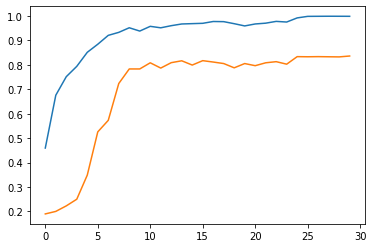

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_ = ReduceLROnPlateau(monitor='val_loss')
history = model.fit([X_train_mfcc_scaled[train_mask], X_train_chroma_stft_scaled[train_mask], X_train_rmse_scaled[train_mask], X_train_spec_cent_scaled[train_mask]],
                    Y_train[train_mask],
                    epochs=30,
                    batch_size=256,
                    validation_data=([X_train_mfcc_scaled[val_mask], X_train_chroma_stft_scaled[val_mask], X_train_rmse_scaled[val_mask], X_train_spec_cent_scaled[val_mask]],
                    Y_train[val_mask]),
                    callbacks=[reduce_])

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()